# Eksperimen Klasifikasi Phishing: TabNet

**Tujuan Notebook:**
1. Memuat dan melakukan pra-pemrosesan pada dataset deteksi phishing.
2. Melakukan hyperparameter tuning pada model TabNet menggunakan Optuna.
3. Menghasilkan dan menyimpan data histori untuk analisis.
4. Melatih model TabNet final dengan parameter terbaik.
5. Mengevaluasi performa model pada test set.
6. Menyimpan metrik hasil evaluasi dan model terlatih untuk analisis.

## Setup Environment

In [1]:
!pip install -q pytorch-tabnet optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# !pip install optuna-integration[pytorch_lightning] -q

### Import Library

In [3]:
import pandas as pd
import numpy as np
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import json
import os
import optuna
import warnings
warnings.filterwarnings('ignore')

print(f"Versi PyTorch: {torch.__version__}")
print(f"Versi Optuna: {optuna.__version__}")
# print(f"Versi Pytorch Tabnet: {TabNetClassifier.__version__}")

Versi PyTorch: 2.6.0+cu124
Versi Optuna: 4.3.0


### Konfigurasi dan Mounting

In [ ]:
# Mount Google Drive (jika belum)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    print("Bukan di lingkungan Colab, pastikan path sudah benar.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Sesuaikan path ini dengan lokasi file Anda di Google Drive
# Pastikan Google Drive sudah di-mount
BASE_PATH = "/content/drive/My Drive/datasets/Phishing_Detection_Dataset/"
TRAINING_DATA_PATH = os.path.join(BASE_PATH, "dataset_training.csv")
TESTING_DATA_PATH = os.path.join(BASE_PATH, "dataset_testing.csv")
OUTPUT_DIR = os.path.join(BASE_PATH, "outputs")

# Membuat direktori output jika belum ada
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Konfigurasi untuk reproduktivitas
RANDOM_STATE = 6037

## Preprocessing Data

In [ ]:
# --- Memuat Data Training dan Testing ---
df_train_full = pd.read_csv(TRAINING_DATA_PATH)
df_test = pd.read_csv(TESTING_DATA_PATH)

# --- Memisahkan Fitur dan Target ---
X_train_full = df_train_full.drop(columns=["Type"]).astype(np.float32)
y_train_full = df_train_full["Type"].astype(int)

X_test = df_test.drop(columns=["Type"]).astype(np.float32)
y_test = df_test["Type"].astype(int)

# --- Membuat Set Validasi dari Data Training ---
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,
    stratify=y_train_full,
    random_state=RANDOM_STATE
)

print(f"Ukuran data training (untuk tuning): {X_train.shape}")
print(f"Ukuran data validasi (untuk tuning): {X_val.shape}")
print(f"Ukuran data test (final):            {X_test.shape}")

# --- Penskalaan Fitur menggunakan StandardScaler (Penting untuk TabNet) ---
scaler_tab = StandardScaler()
# Scaler HANYA "belajar" (di-fit) dari data training (X_train)
scaler_tab.fit(X_train)

# Terapkan scaler yang sama ke semua set data
X_train_tab = scaler_tab.transform(X_train)
X_val_tab = scaler_tab.transform(X_val)
X_test_tab = scaler_tab.transform(X_test)
X_train_full_tab = scaler_tab.transform(X_train_full)

Ukuran data training (untuk tuning): (178524, 41)
Ukuran data validasi (untuk tuning): (44631, 41)
Ukuran data test (final):            (24795, 41)


## Hyperparameter Tuning

In [ ]:
class CustomOptunaPruningCallback(Callback):
    """
    Callback kustom yang melacak skor terbaik dan melakukan pruning.
    """
    def __init__(self, trial, monitor="val_auc"):
        self.trial = trial
        self.monitor = monitor
        # Inisialisasi skor terbaik dengan nilai yang sangat kecil
        self.best_score = -np.inf

    def on_epoch_end(self, epoch, logs=None):
        """
        Metode ini dipanggil oleh TabNet di setiap akhir epoch.
        """
        score = logs.get(self.monitor)
        if score is not None:
            # Perbarui skor terbaik jika skor saat ini lebih tinggi
            if score > self.best_score:
                self.best_score = score

            # Laporkan skor saat ini ke Optuna untuk keputusan pruning
            self.trial.report(score, epoch)

            # Periksa apakah trial ini harus dihentikan
            if self.trial.should_prune():
                message = f"Trial was pruned at epoch {epoch}."
                raise optuna.exceptions.TrialPruned(message)

In [ ]:
print("Memulai Hyperparameter Tuning untuk TabNet dengan Custom Pruning Callback...")

def objective_tabnet(trial: optuna.Trial):
    # Ruang pencarian tetap sama
    mask_type = trial.suggest_categorical("mask_type", ["sparsemax", "entmax"])
    n_d = trial.suggest_int("n_d", 8, 32, log=True)
    n_steps = trial.suggest_int("n_steps", 3, 8)
    gamma = trial.suggest_float("gamma", 1.0, 2.0)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True)
    lr = trial.suggest_float("lr", 1e-3, 3e-2, log=True)

    clf = TabNetClassifier(
        n_d=n_d, n_a=n_d, n_steps=n_steps, gamma=gamma,
        lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.AdamW,
        optimizer_params=dict(lr=lr), mask_type=mask_type,
        scheduler_params={"mode": "max", "patience": 5},
        scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
        verbose=0, seed=RANDOM_STATE
    )

    # Gunakan callback kustom yang baru
    pruning_callback = CustomOptunaPruningCallback(trial, monitor="val_auc")

    try:
        clf.fit(
            X_train=X_train_tab, y_train=y_train.values,
            eval_set=[(X_val_tab, y_val.values)],
            eval_name=["val"],
            eval_metric=["auc", "accuracy", "logloss"],
            max_epochs=50,
            patience=10, batch_size=2048, virtual_batch_size=256,
            callbacks=[pruning_callback]
        )
    except optuna.exceptions.TrialPruned as e:
        # Jika trial di-prune, kita tetap ingin mengembalikan skor terbaik yang pernah dicapai
        # sebelum dihentikan. Ini memastikan Optuna masih memiliki data yang valid.
        print(e)
        return pruning_callback.best_score

    # PERBAIKAN FINAL: Kembalikan skor terbaik yang disimpan oleh callback kita.
    return pruning_callback.best_score

# Sisa kode untuk menjalankan study tetap sama
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
study_tabnet = optuna.create_study(direction="maximize", pruner=pruner)
study_tabnet.optimize(objective_tabnet, n_trials=30)

# Tampilkan hasil
print("\n=====================================================")
print("Tuning Selesai.")
best_trial = study_tabnet.best_trial
best_params_tabnet = best_trial.params
print(f"Best AUC from validation: {best_trial.value:.4f}")
print("Best TabNet params:")
print(best_params_tabnet)

[I 2025-06-14 17:22:02,063] A new study created in memory with name: no-name-ba381635-ea2a-4054-8ad9-b0e88e44e547


Memulai Hyperparameter Tuning untuk TabNet dengan Custom Pruning Callback...

Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_logloss = 0.29188


[I 2025-06-14 17:32:29,903] Trial 0 finished with value: 0.9457420735089089 and parameters: {'mask_type': 'sparsemax', 'n_d': 26, 'n_steps': 8, 'gamma': 1.095013130743121, 'lambda_sparse': 0.00010860868441098263, 'lr': 0.02361066386216823}. Best is trial 0 with value: 0.9457420735089089.


Stop training because you reached max_epochs = 50 with best_epoch = 43 and best_val_logloss = 0.26328


[I 2025-06-14 17:37:53,313] Trial 1 finished with value: 0.9553648855184736 and parameters: {'mask_type': 'sparsemax', 'n_d': 22, 'n_steps': 3, 'gamma': 1.7286275857189284, 'lambda_sparse': 0.0001110907626202433, 'lr': 0.012083112186967379}. Best is trial 1 with value: 0.9553648855184736.



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_logloss = 0.48206


[I 2025-06-14 17:43:32,236] Trial 2 finished with value: 0.8542977726721824 and parameters: {'mask_type': 'sparsemax', 'n_d': 9, 'n_steps': 7, 'gamma': 1.4018661845281235, 'lambda_sparse': 0.0008965660698557937, 'lr': 0.0011302278844727797}. Best is trial 1 with value: 0.9553648855184736.



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_logloss = 0.29065


[I 2025-06-14 17:49:54,093] Trial 3 finished with value: 0.945826582365084 and parameters: {'mask_type': 'sparsemax', 'n_d': 31, 'n_steps': 5, 'gamma': 1.5118141161703256, 'lambda_sparse': 2.904346042802058e-06, 'lr': 0.008465447899558253}. Best is trial 1 with value: 0.9553648855184736.



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_logloss = 0.37971


[I 2025-06-14 17:57:26,154] Trial 4 finished with value: 0.9082669880558591 and parameters: {'mask_type': 'sparsemax', 'n_d': 9, 'n_steps': 8, 'gamma': 1.536985443775631, 'lambda_sparse': 1.212367351381075e-05, 'lr': 0.01208669986220743}. Best is trial 1 with value: 0.9553648855184736.



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_logloss = 0.28613


[I 2025-06-14 18:03:40,833] Trial 5 finished with value: 0.9476673045890067 and parameters: {'mask_type': 'sparsemax', 'n_d': 26, 'n_steps': 6, 'gamma': 1.1481866698381644, 'lambda_sparse': 5.659651317607247e-06, 'lr': 0.008496531415381273}. Best is trial 1 with value: 0.9553648855184736.



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_logloss = 0.28048


[I 2025-06-14 18:09:16,545] Trial 6 finished with value: 0.9503125562720345 and parameters: {'mask_type': 'entmax', 'n_d': 18, 'n_steps': 7, 'gamma': 1.295888318276524, 'lambda_sparse': 7.583630446938097e-06, 'lr': 0.013538155229152742}. Best is trial 1 with value: 0.9553648855184736.
[I 2025-06-14 18:10:15,329] Trial 7 finished with value: 0.9250688105045661 and parameters: {'mask_type': 'entmax', 'n_d': 18, 'n_steps': 6, 'gamma': 1.720007799125589, 'lambda_sparse': 4.5304194754899116e-05, 'lr': 0.009854029290135218}. Best is trial 1 with value: 0.9553648855184736.


Trial was pruned at epoch 5.
Stop training because you reached max_epochs = 50 with best_epoch = 42 and best_val_logloss = 0.26053


[I 2025-06-14 18:16:36,619] Trial 8 finished with value: 0.9563898304123527 and parameters: {'mask_type': 'entmax', 'n_d': 12, 'n_steps': 4, 'gamma': 1.3035295560074853, 'lambda_sparse': 1.1054372901117321e-06, 'lr': 0.009463088970617796}. Best is trial 8 with value: 0.9563898304123527.



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_logloss = 0.25925


[I 2025-06-14 18:20:16,659] Trial 9 finished with value: 0.9570051862881114 and parameters: {'mask_type': 'entmax', 'n_d': 32, 'n_steps': 4, 'gamma': 1.4595400531267613, 'lambda_sparse': 0.0003074384614769114, 'lr': 0.005218091585578477}. Best is trial 9 with value: 0.9570051862881114.
[I 2025-06-14 18:21:07,348] Trial 10 finished with value: 0.9409273462348874 and parameters: {'mask_type': 'entmax', 'n_d': 14, 'n_steps': 3, 'gamma': 1.8630754181045324, 'lambda_sparse': 0.0007859017189058222, 'lr': 0.003014789824471889}. Best is trial 9 with value: 0.9570051862881114.


Trial was pruned at epoch 7.

Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_logloss = 0.28465


[I 2025-06-14 18:25:29,153] Trial 11 finished with value: 0.9486984857867977 and parameters: {'mask_type': 'entmax', 'n_d': 12, 'n_steps': 4, 'gamma': 1.289687853388309, 'lambda_sparse': 1.030745695097834e-06, 'lr': 0.003925682312724454}. Best is trial 9 with value: 0.9570051862881114.
[I 2025-06-14 18:27:00,487] Trial 12 finished with value: 0.9471619387331507 and parameters: {'mask_type': 'entmax', 'n_d': 12, 'n_steps': 4, 'gamma': 1.0110997967240762, 'lambda_sparse': 0.00024577289873868244, 'lr': 0.0024361667675068784}. Best is trial 9 with value: 0.9570051862881114.


Trial was pruned at epoch 11.

Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_logloss = 0.27813


[I 2025-06-14 18:31:39,238] Trial 13 finished with value: 0.9505437409449411 and parameters: {'mask_type': 'entmax', 'n_d': 11, 'n_steps': 4, 'gamma': 1.3385741350037126, 'lambda_sparse': 2.8654030996728493e-05, 'lr': 0.005477926139415542}. Best is trial 9 with value: 0.9570051862881114.



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_logloss = 0.26252


[I 2025-06-14 18:37:39,138] Trial 14 finished with value: 0.9558205982483728 and parameters: {'mask_type': 'entmax', 'n_d': 16, 'n_steps': 5, 'gamma': 1.6266105929449757, 'lambda_sparse': 1.5981043429359346e-06, 'lr': 0.023995679510719976}. Best is trial 9 with value: 0.9570051862881114.
[I 2025-06-14 18:38:23,928] Trial 15 finished with value: 0.9419871106598645 and parameters: {'mask_type': 'entmax', 'n_d': 8, 'n_steps': 4, 'gamma': 1.1929765984710894, 'lambda_sparse': 0.00029922406127244584, 'lr': 0.005333006963361449}. Best is trial 9 with value: 0.9570051862881114.


Trial was pruned at epoch 5.

Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_logloss = 0.2808


[I 2025-06-14 18:41:51,938] Trial 16 finished with value: 0.9497356317951027 and parameters: {'mask_type': 'entmax', 'n_d': 21, 'n_steps': 3, 'gamma': 1.4309607427822484, 'lambda_sparse': 2.4180964404133665e-05, 'lr': 0.0018529368344145146}. Best is trial 9 with value: 0.9570051862881114.
[I 2025-06-14 18:42:53,824] Trial 17 finished with value: 0.9454792467831954 and parameters: {'mask_type': 'entmax', 'n_d': 32, 'n_steps': 5, 'gamma': 1.9715774704123752, 'lambda_sparse': 6.477838530509071e-05, 'lr': 0.005631725728967957}. Best is trial 9 with value: 0.9570051862881114.


Trial was pruned at epoch 6.

Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_logloss = 0.25798


[I 2025-06-14 18:47:25,554] Trial 18 finished with value: 0.9570663839166828 and parameters: {'mask_type': 'entmax', 'n_d': 14, 'n_steps': 4, 'gamma': 1.5982994239498007, 'lambda_sparse': 0.00021826590137318696, 'lr': 0.018886025102170228}. Best is trial 18 with value: 0.9570663839166828.



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_logloss = 0.24774


[I 2025-06-14 18:51:19,572] Trial 19 finished with value: 0.9605247201174557 and parameters: {'mask_type': 'entmax', 'n_d': 15, 'n_steps': 3, 'gamma': 1.6414457751856562, 'lambda_sparse': 0.00033160101706492114, 'lr': 0.017910723140548764}. Best is trial 19 with value: 0.9605247201174557.



Early stopping occurred at epoch 43 with best_epoch = 33 and best_val_logloss = 0.24222


[I 2025-06-14 18:55:54,361] Trial 20 finished with value: 0.9620086959938796 and parameters: {'mask_type': 'entmax', 'n_d': 16, 'n_steps': 3, 'gamma': 1.6517852842531042, 'lambda_sparse': 0.000431175421898897, 'lr': 0.018316000666599008}. Best is trial 20 with value: 0.9620086959938796.



Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_logloss = 0.24413


[I 2025-06-14 18:59:34,010] Trial 21 finished with value: 0.9612054878026461 and parameters: {'mask_type': 'entmax', 'n_d': 14, 'n_steps': 3, 'gamma': 1.641418061653205, 'lambda_sparse': 0.00047574460412586446, 'lr': 0.029893751249007935}. Best is trial 20 with value: 0.9620086959938796.


Stop training because you reached max_epochs = 50 with best_epoch = 41 and best_val_logloss = 0.24031


[I 2025-06-14 19:04:50,273] Trial 22 finished with value: 0.9625146681849919 and parameters: {'mask_type': 'entmax', 'n_d': 15, 'n_steps': 3, 'gamma': 1.7411037954173751, 'lambda_sparse': 0.0005504627598522792, 'lr': 0.029819345890579656}. Best is trial 22 with value: 0.9625146681849919.



Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_logloss = 0.24221


[I 2025-06-14 19:09:08,526] Trial 23 finished with value: 0.961800482679063 and parameters: {'mask_type': 'entmax', 'n_d': 17, 'n_steps': 3, 'gamma': 1.7938193795350132, 'lambda_sparse': 0.000558549114979045, 'lr': 0.02778417614811713}. Best is trial 22 with value: 0.9625146681849919.



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_logloss = 0.24512


[I 2025-06-14 19:12:15,055] Trial 24 finished with value: 0.9611119231333409 and parameters: {'mask_type': 'entmax', 'n_d': 18, 'n_steps': 3, 'gamma': 1.835470539002909, 'lambda_sparse': 0.000610262493355257, 'lr': 0.017017105569827287}. Best is trial 22 with value: 0.9625146681849919.



Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_logloss = 0.24713


[I 2025-06-14 19:15:51,275] Trial 25 finished with value: 0.9604719950939735 and parameters: {'mask_type': 'entmax', 'n_d': 16, 'n_steps': 3, 'gamma': 1.7922370539641574, 'lambda_sparse': 0.0001214349553768184, 'lr': 0.029750943313411993}. Best is trial 22 with value: 0.9625146681849919.



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_logloss = 0.2421


[I 2025-06-14 19:18:58,295] Trial 26 finished with value: 0.9620214431116957 and parameters: {'mask_type': 'entmax', 'n_d': 20, 'n_steps': 3, 'gamma': 1.9614764395697348, 'lambda_sparse': 0.0009733417349932649, 'lr': 0.022976742545435427}. Best is trial 22 with value: 0.9625146681849919.
[I 2025-06-14 19:19:47,467] Trial 27 finished with value: 0.9430941511352666 and parameters: {'mask_type': 'entmax', 'n_d': 21, 'n_steps': 5, 'gamma': 1.9094956999414234, 'lambda_sparse': 0.0008416884702040715, 'lr': 0.021742881840480083}. Best is trial 22 with value: 0.9625146681849919.


Trial was pruned at epoch 5.

Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_logloss = 0.24935


[I 2025-06-14 19:23:00,178] Trial 28 finished with value: 0.9598615984976238 and parameters: {'mask_type': 'entmax', 'n_d': 23, 'n_steps': 3, 'gamma': 1.9849869840018557, 'lambda_sparse': 0.0001530065355984375, 'lr': 0.014634450435393671}. Best is trial 22 with value: 0.9625146681849919.
[I 2025-06-14 19:23:42,105] Trial 29 finished with value: 0.9414257337048758 and parameters: {'mask_type': 'sparsemax', 'n_d': 20, 'n_steps': 4, 'gamma': 1.7226684008557114, 'lambda_sparse': 0.00043367868808219306, 'lr': 0.022573522351474185}. Best is trial 22 with value: 0.9625146681849919.


Trial was pruned at epoch 5.

Tuning Selesai.
Best AUC from validation: 0.9625
Best TabNet params:
{'mask_type': 'entmax', 'n_d': 15, 'n_steps': 3, 'gamma': 1.7411037954173751, 'lambda_sparse': 0.0005504627598522792, 'lr': 0.029819345890579656}


### Simpan Data History

In [ ]:
print("Membuat data histori dengan parameter terbaik...")

# Ambil parameter terbaik dari hasil tuning
best_params_tabnet = study_tabnet.best_params

# PERBAIKAN: Pisahkan 'lr' dari kamus utama
# Gunakan .pop() untuk mengambil nilai sekaligus menghapusnya dari kamus
learning_rate = best_params_tabnet.pop('lr')

# Buat instance model dengan argumen yang sudah disusun ulang
history_model_1 = TabNetClassifier(
    **best_params_tabnet,  # Sekarang berisi sisa parameter (n_d, gamma, dll)
    n_a=best_params_tabnet['n_d'],
    optimizer_fn=torch.optim.AdamW,
    optimizer_params={'lr': learning_rate}, # Serahkan 'lr' di dalam kamus ini
    seed=RANDOM_STATE,
    verbose=1
)

# Latih model ini pada data training, dan evaluasi pada data validasi
history_model_1.fit(
    X_train=X_train_tab, y_train=y_train.values,
    eval_set=[(X_train_tab, y_train.values), (X_val_tab, y_val.values)],
    eval_name=['train', 'val'],
    eval_metric=['logloss', 'accuracy', 'auc'],
    max_epochs=50, # Latih lebih lama untuk mendapatkan grafik yang bagus
    patience=15,
    batch_size=2048,
    virtual_batch_size=256
)

# Ambil dan simpan histori
tabnet_history = history_model_1.history
history_path = os.path.join(OUTPUT_DIR, 'tabnet_history.json')

# Konversi nilai numpy ke tipe data dasar Python agar bisa disimpan sebagai JSON
serializable_history = {k: [float(i) for i in v] for k, v in tabnet_history.history.items()}

with open(history_path, 'w') as f:
    json.dump(serializable_history, f, indent=4)

print(f"\nData histori untuk grafik berhasil dibuat dan disimpan di: {history_path}")

Membuat data histori dengan parameter terbaik...
epoch 0  | loss: 0.40443 | train_logloss: 0.31833 | train_accuracy: 0.86316 | train_auc: 0.93554 | val_logloss: 0.32323 | val_accuracy: 0.86057 | val_auc: 0.9333  |  0:00:09s
epoch 1  | loss: 0.31359 | train_logloss: 0.28956 | train_accuracy: 0.87694 | train_auc: 0.94693 | val_logloss: 0.293   | val_accuracy: 0.87441 | val_auc: 0.94551 |  0:00:17s
epoch 2  | loss: 0.29231 | train_logloss: 0.27964 | train_accuracy: 0.88107 | train_auc: 0.95188 | val_logloss: 0.28384 | val_accuracy: 0.87941 | val_auc: 0.95027 |  0:00:26s
epoch 3  | loss: 0.28128 | train_logloss: 0.26806 | train_accuracy: 0.88889 | train_auc: 0.95455 | val_logloss: 0.27336 | val_accuracy: 0.88622 | val_auc: 0.95238 |  0:00:36s
epoch 4  | loss: 0.27465 | train_logloss: 0.27529 | train_accuracy: 0.88412 | train_auc: 0.95365 | val_logloss: 0.28101 | val_accuracy: 0.88174 | val_auc: 0.95172 |  0:00:44s
epoch 5  | loss: 0.27183 | train_logloss: 0.26033 | train_accuracy: 0.89222 

In [ ]:
# history_path = os.path.join(OUTPUT_DIR, 'tabnet_history.json')

# Muat data histori dari file JSON
try:
    with open(history_path, 'r') as f:
        tabnet_history = json.load(f)
    print("✅ Data histori TabNet berhasil dimuat.")
except FileNotFoundError:
    print(f"❌ Error: File tidak ditemukan di '{history_path}'. Pastikan notebook eksperimen TabNet sudah dijalankan dan berhasil menyimpan file.")
    tabnet_history = None

✅ Data histori TabNet berhasil dimuat.


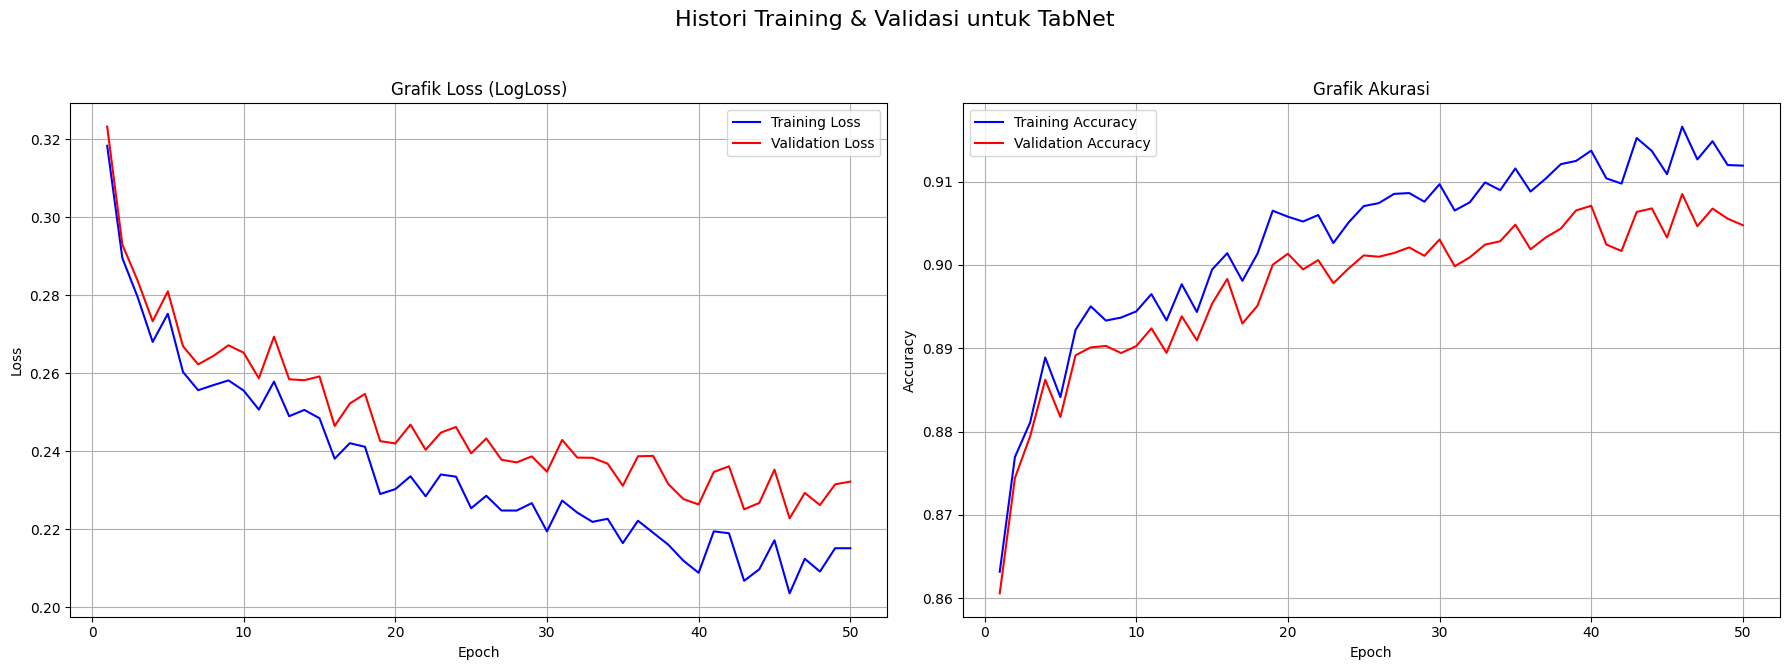

In [ ]:
import matplotlib.pyplot as plt

def plot_tabnet_history(history, model_name="TabNet"):
    """
    Membuat plot grafik loss dan akurasi dari histori training TabNet.
    """
    if not history:
        print("Data histori tidak tersedia untuk di-plot.")
        return

    # Ekstrak data dari dictionary histori
    # Pustaka pytorch-tabnet menamai logs dengan nama eval_set, yaitu 'train' dan 'val'
    train_loss = history.get('train_logloss', [])
    val_loss = history.get('val_logloss', [])
    train_acc = history.get('train_accuracy', [])
    val_acc = history.get('val_accuracy', [])

    # Periksa apakah data ada sebelum membuat plot
    if not train_loss or not val_loss:
        print("Data loss tidak ditemukan dalam histori.")
        return

    epochs = range(1, len(train_loss) + 1)

    # Buat 2 plot: satu untuk loss, satu untuk akurasi
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle(f'Histori Training & Validasi untuk {model_name}', fontsize=16)

    # Plot Loss
    ax1.plot(epochs, train_loss, 'b-', label='Training Loss')
    ax1.plot(epochs, val_loss, 'r-', label='Validation Loss')
    ax1.set_title('Grafik Loss (LogLoss)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot Akurasi
    if train_acc and val_acc:
        ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy')
        ax2.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
        ax2.set_title('Grafik Akurasi')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
    else:
        ax2.set_title('Data Akurasi Tidak Tersedia')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Panggil fungsi untuk membuat plot jika data histori berhasil dimuat
if tabnet_history:
    plot_tabnet_history(tabnet_history)

## Training Final Model

In [ ]:
print("Melatih model final TabNet dengan parameter terbaik pada SELURUH data training...")

# Buat instance model final
final_tabnet_model = TabNetClassifier(
    **best_params_tabnet,  # Sekarang berisi sisa parameter (n_d, gamma, dll)
    n_a=best_params_tabnet['n_d'],
    optimizer_fn=torch.optim.AdamW,
    optimizer_params={'lr': learning_rate}, # Serahkan 'lr' di dalam kamus ini
    seed=RANDOM_STATE,
    verbose=1
)


# Latih pada seluruh data training (dari dataset_training.csv)
final_tabnet_model.fit(
    X_train=X_train_full_tab,
    y_train=y_train_full.values,
    max_epochs=history_model_1.best_epoch, # Latih hanya sampai epoch terbaik dari run histori
    batch_size=2048,
    virtual_batch_size=256
)

print("Pelatihan model final selesai.")

Melatih model final TabNet dengan parameter terbaik pada SELURUH data training...
epoch 0  | loss: 0.3858  |  0:00:05s
epoch 1  | loss: 0.30588 |  0:00:12s
epoch 2  | loss: 0.28835 |  0:00:18s
epoch 3  | loss: 0.27936 |  0:00:25s
epoch 4  | loss: 0.27279 |  0:00:32s
epoch 5  | loss: 0.26623 |  0:00:39s
epoch 6  | loss: 0.2627  |  0:00:45s
epoch 7  | loss: 0.25885 |  0:00:52s
epoch 8  | loss: 0.25723 |  0:00:58s
epoch 9  | loss: 0.2541  |  0:01:05s
epoch 10 | loss: 0.25097 |  0:01:10s
epoch 11 | loss: 0.24916 |  0:01:17s
epoch 12 | loss: 0.24661 |  0:01:23s
epoch 13 | loss: 0.24488 |  0:01:30s
epoch 14 | loss: 0.24449 |  0:01:36s
epoch 15 | loss: 0.24201 |  0:01:43s
epoch 16 | loss: 0.23982 |  0:01:49s
epoch 17 | loss: 0.24312 |  0:01:55s
epoch 18 | loss: 0.23917 |  0:02:02s
epoch 19 | loss: 0.23765 |  0:02:08s
epoch 20 | loss: 0.23651 |  0:02:15s
epoch 21 | loss: 0.23498 |  0:02:21s
epoch 22 | loss: 0.23413 |  0:02:28s
epoch 23 | loss: 0.2329  |  0:02:38s
epoch 24 | loss: 0.2326  |  0:

In [ ]:
model_path = os.path.join(OUTPUT_DIR, 'best_tabnet_model')
saved_path = final_tabnet_model.save_model(model_path)
print(f"Model terbaik telah disimpan di: {saved_path}")

Successfully saved model at /content/drive/My Drive/datasets/Phishing_Detection_Dataset/outputs/best_tabnet_model.zip
Model terbaik telah disimpan di: /content/drive/My Drive/datasets/Phishing_Detection_Dataset/outputs/best_tabnet_model.zip


## Evaluasi Model

In [ ]:
print("Mengevaluasi model final pada test set...")

# Lakukan prediksi pada data test
# TabNet akan otomatis menggunakan GPU jika tersedia
y_pred_tabnet_best = final_tabnet_model.predict(X_test_tab)

# Hitung metrik performa
tabnet_metrics = {
    'Model': 'TabNet (Tuned)',
    'Device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'Accuracy': accuracy_score(y_test, y_pred_tabnet_best),
    'Precision': precision_score(y_test, y_pred_tabnet_best),
    'Recall': recall_score(y_test, y_pred_tabnet_best),
    'F1-score': f1_score(y_test, y_pred_tabnet_best)
}

# Ukur kecepatan inferensi
inference_times = []
for _ in range(10):
    start_time = time.perf_counter()
    _ = final_tabnet_model.predict(X_test_tab)
    end_time = time.perf_counter()
    inference_times.append((end_time - start_time) * 1000)

tabnet_metrics['Inference Time (ms/sample)'] = np.mean(inference_times) / len(X_test_tab)

print("\n--- Metrik Final TabNet ---")
for key, value in tabnet_metrics.items():
        if isinstance(value, float):
          print(f"{key:<25}: {value:.6f}")
        else:
          print(f"{key:<25}: {value}")

Mengevaluasi model final pada test set...

--- Metrik Final TabNet ---
Model                    : TabNet (Tuned)
Device                   : cuda
Accuracy                 : 0.905908
Precision                : 0.929456
Recall                   : 0.873658
F1-score                 : 0.900694
Inference Time (ms/sample): 0.026675


In [ ]:
# --- Evaluasi Inferensi TabNet di CPU ---

print("\n--- Memulai Evaluasi di CPU ---")

# Path ke model .zip yang sudah disimpan dari sel sebelumnya
# Pastikan sel penyimpanan model sudah dijalankan
# model_path = os.path.join(OUTPUT_DIR, 'best_tabnet_model.zip')

# 1. Buat instance model baru dengan device='cpu'
# Gunakan parameter terbaik yang sama dari hasil tuning
# best_params_tabnet harus sudah ada dari sel tuning
cpu_tabnet_model = TabNetClassifier(
    **best_params_tabnet,
    n_a=best_params_tabnet['n_d'],
    optimizer_fn=torch.optim.AdamW,
    optimizer_params={'lr': learning_rate},
    device_name='cpu',  # <-- Memaksa model untuk berjalan di CPU
    seed=RANDOM_STATE
)

# 2. Muat bobot dari model yang sudah dilatih ke instance CPU baru
cpu_tabnet_model.load_model(saved_path)

print("Model berhasil dimuat ke dalam mode CPU.")

# 3. Lakukan prediksi pada data test di CPU
# X_test_tab adalah numpy array yang sudah ada di memori CPU
y_pred_tabnet_cpu = cpu_tabnet_model.predict(X_test_tab)

# 4. Hitung metrik performa (seharusnya sama persis dengan versi GPU)
tabnet_cpu_metrics = {
    'Model': 'TabNet (Tuned)',
    'Device': 'cpu',
    'Accuracy': accuracy_score(y_test, y_pred_tabnet_cpu),
    'Precision': precision_score(y_test, y_pred_tabnet_cpu),
    'Recall': recall_score(y_test, y_pred_tabnet_cpu),
    'F1-score': f1_score(y_test, y_pred_tabnet_cpu)
}

# 5. Ukur kecepatan inferensi di CPU (rata-rata dari 50 eksekusi)
cpu_inference_times = []
for _ in range(10):
    start_time = time.perf_counter()
    _ = cpu_tabnet_model.predict(X_test_tab)
    end_time = time.perf_counter()
    cpu_inference_times.append((end_time - start_time) * 1000)

tabnet_cpu_metrics['Inference Time (ms/sample)'] = np.mean(cpu_inference_times) / len(X_test_tab)

print("\nMetrik Kinerja di CPU:")
for key, value in tabnet_cpu_metrics.items():
        if isinstance(value, float):
          print(f"{key:<25}: {value:.6f}")
        else:
          print(f"{key:<25}: {value}")


--- Memulai Evaluasi di CPU ---
Model berhasil dimuat ke dalam mode CPU.

Metrik Kinerja di CPU:
Model                    : TabNet (Tuned)
Device                   : cpu
Accuracy                 : 0.905908
Precision                : 0.929456
Recall                   : 0.873658
F1-score                 : 0.900694
Inference Time (ms/sample): 0.034551


## Menyimpan Model

In [ ]:
# Tentukan path file output
metrics_path = os.path.join(OUTPUT_DIR, 'tabnet_results.json')
# pytorch-tabnet menyimpan model sebagai .zip
# model_path = os.path.join(OUTPUT_DIR, 'best_tabnet_model') # tanpa ekstensi

# Simpan metrik ke file JSON
with open(metrics_path, 'w') as f:
    json.dump(tabnet_metrics, f, indent=4)

# Simpan model terlatih
# Ini akan membuat file 'best_tabnet_model.zip'
# saved_path = final_tabnet_model.save_model(model_path)

print(f"\nMetrik evaluasi telah disimpan di: {metrics_path}")
print(f"Model terbaik telah disimpan di: {saved_path}")


Metrik evaluasi telah disimpan di: /content/drive/My Drive/datasets/Phishing_Detection_Dataset/outputs/tabnet_results.json
Model terbaik telah disimpan di: /content/drive/My Drive/datasets/Phishing_Detection_Dataset/outputs/best_tabnet_model.zip
